# Part I - Exploratory Data Analysis

---

1. Import packages
2. Loading data with Pandas
3. Descriptive statistics of data
4. Data Cleaning
5. Data visualization

---

## 1. Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pylab
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

---

## 2. Loading data with Pandas

We need to load `amazon_sales_clean.csv` into individual dataframes so that we can work with them in Python.

In [2]:
df = pd.read_csv("Amazon_sales.csv", index_col=False)

Let's look at the first 5 rows of both dataframes to see what the data looks like.

In [3]:
df.head()

,Unnamed: 0,date,status,fulfilment,sales_channel,ship_service_level,category,size,amazon_standard_id,qty,currency,sales,ship_state,clean_ship_state,promotion_used
0,2,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,kurta,XL,B07WV4JV4D,1,INR,329.0,MAHARASHTRA,Maharashtra,True
1,4,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,Top,3XL,B098714BZP,1,INR,574.0,TAMIL NADU,Tamil Nadu,False
2,5,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,Set,XL,B08YN7XDSG,1,INR,824.0,UTTAR PRADESH,Uttar Pradesh,True
3,6,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,Set,L,B08CMHNWBN,1,INR,653.0,CHANDIGARH,Chandigarh,True
4,9,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,kurta,XXL,B08B3XF5MH,1,INR,363.0,TAMIL NADU,Tamil Nadu,False


With the data above, we have a mix of numeric and categorical data, also we have NaN values which we will need to handle later.

---

## 3. Descriptive statistics of data

### Data types

It is useful to first understand the data that we're dealing with along with the data types of each column. The data types may dictate how we transform and engineer features.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77785 entries, 0 to 77784
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          77785 non-null  int64  
 1   date                77785 non-null  object 
 2   status              77785 non-null  object 
 3   fulfilment          77785 non-null  object 
 4   sales_channel       77785 non-null  object 
 5   ship_service_level  77785 non-null  object 
 6   category            77785 non-null  object 
 7   size                77785 non-null  object 
 8   amazon_standard_id  77785 non-null  object 
 9   qty                 77785 non-null  int64  
 10  currency            77577 non-null  object 
 11  sales               77577 non-null  float64
 12  ship_state          77785 non-null  object 
 13  clean_ship_state    77785 non-null  object 
 14  promotion_used      77785 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(11)
memory u

We can see that `date` column is not currently in datetime format. We will need to convert these later.

### Statistics

Now let's look at some statistics about the datasets

In [5]:
num_col = ['qty', 'sales']
df[num_col].describe().T

,count,mean,std,min,25%,50%,75%,max
qty,77785.0,1.002635,0.105543,0.0,1.0,1.0,1.0,15.0
sales,77577.0,648.538149,282.432386,0.0,442.0,599.0,788.0,5584.0


The describe method gives us a lot of information about the data. The key point to take away from this are that 1) we have highly skewed data, as exhibited by the percentile values and 2) there is no negative value which means the number is valid.

---

## 4. Data cleaning

### Copy data

Before we clean our data, better to copy the original dataset.

In [6]:
data = df.copy()

### Changing data type

Since `date` column is not currently in datetime format, we should convert it.

In [7]:
data['date'] = pd.to_datetime(data['date'])

### Drop columns

We have 2 columns: `Unnamed: 0` and `ship_state` which we don't need for this project, so we will drop that.

In [8]:
data = data.drop(columns=['Unnamed: 0', 'ship_state'])

### Missing values

We need to check missing values to select the best method for handling missing values.

In [9]:
data.isnull().sum()

date                    0
status                  0
fulfilment              0
sales_channel           0
ship_service_level      0
category                0
size                    0
amazon_standard_id      0
qty                     0
currency              208
sales                 208
clean_ship_state        0
promotion_used          0
dtype: int64

From the data above, there are 2 columns which have missing values. We will handle it one by one.

#### currency column

In `currency` column, we will fill all missing values with `INR` since the data is about Amazon - India.

In [10]:
data['currency'] = data['currency'].fillna(value='INR')

#### sales column

In `sales` column, before filling all missing values, we will explore first.

In [11]:
# define missing per day variable
missing_per_day = data[data['sales'].isnull()].groupby('date').size()

In [12]:
# look at 5 first row
missing_per_day.head()

date
2022-03-31    1
2022-04-01    5
2022-04-02    2
2022-04-03    1
2022-04-04    1
dtype: int64

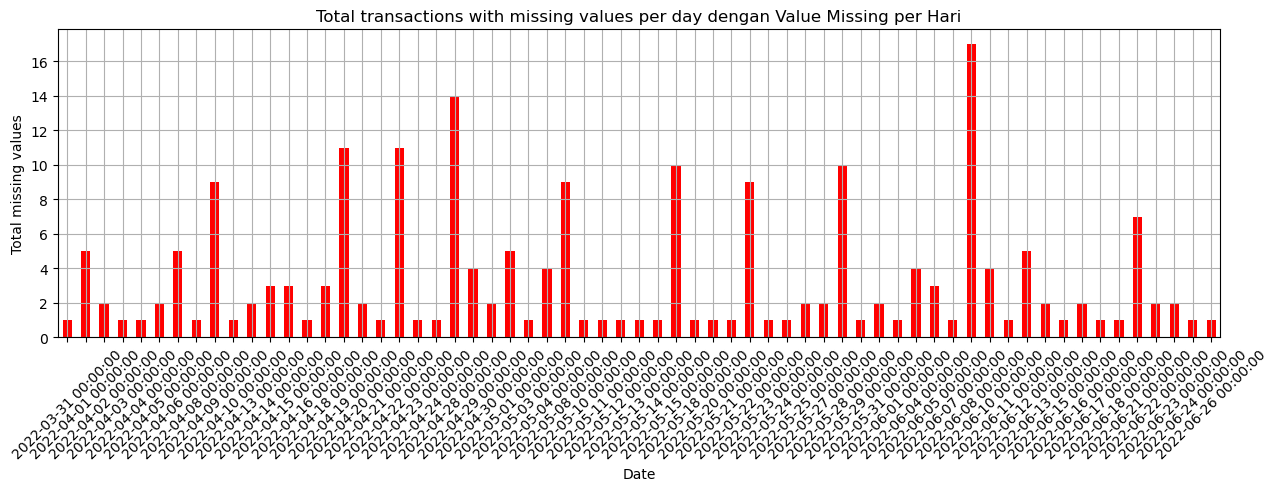

In [13]:
# plot into bar chart
plt.figure(figsize=(15, 4))
missing_per_day.plot(kind='bar', color='red')
plt.title('Total transactions with missing values per day dengan Value Missing per Hari')
plt.xlabel('Date')
plt.ylabel('Total missing values')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

The key point to take away from the chart above is that the number of missing values per day varies and is not consistent from day to day. Additionally, missing values do not occur every single day.

In [14]:
# fill missing values using median

data['sales'] = data.groupby('date')['sales'].transform(lambda x: x.fillna(x.median()))

Since we have fluctuative data in missing values and non-linear, then we fill the missing values using median value.

### Save data for modelling

In [15]:
data.to_csv('data_for_modelling.csv', index=False)

Overall the data looks good now.

---

## 5. Data visualization

Now let's dive a bit deeper into the dataframes

### Sales trend

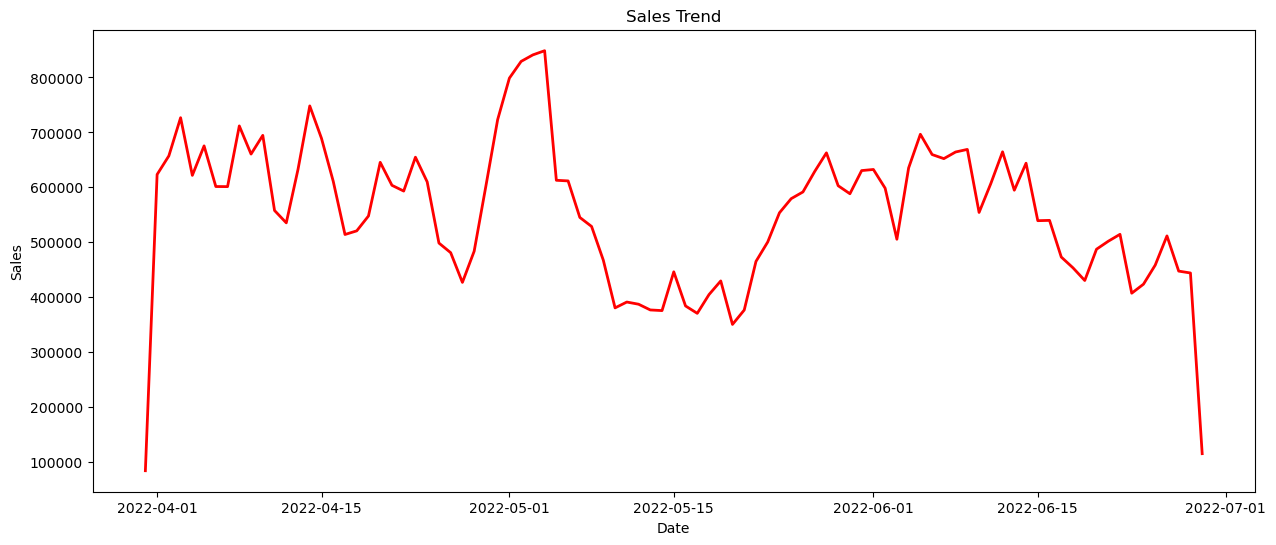

In [16]:
# how's the trend of sales

data_trend = data.groupby('date')['sales'].sum()

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(data_trend.index, data_trend, color='red', linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Sales Trend')

# Show the plot
plt.show()

The chart above shows a decreasing trend over time.

### Decompose trend, season, and residual

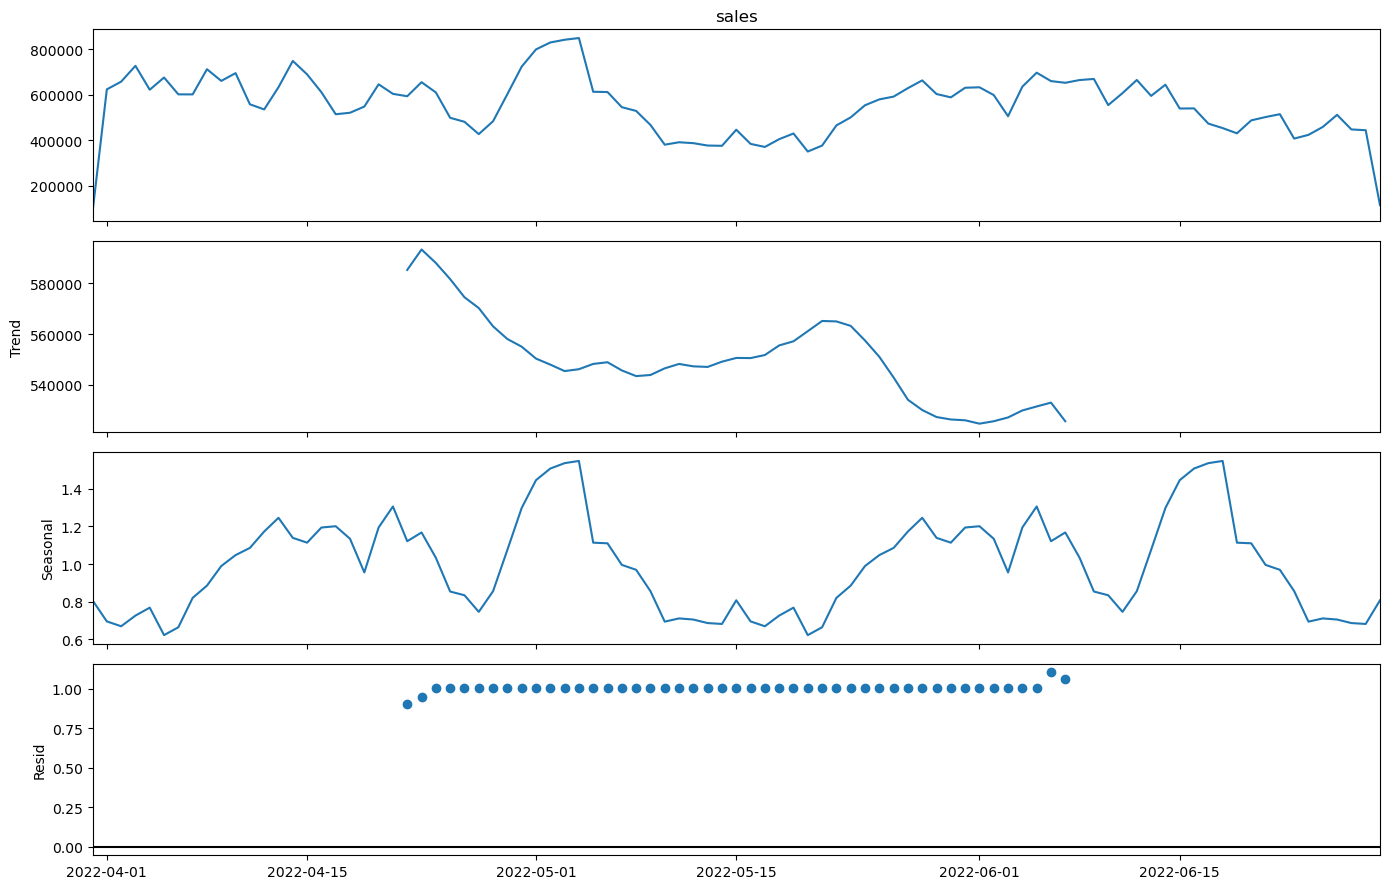

In [17]:
# Decompose the components from the time series.

pylab.rcParams['figure.figsize'] = (14, 9)
res = seasonal_decompose(data_trend, model='multiplicative', period=45)
ax=res.plot()
plt.show()


As mentioned earlier, the trend is decreasing. There appears to be a seasonal pattern occurring approximately every 1.5 months or 45 days (March 31st and May 15th).

From the residual plot, we can see that the residual values are centered around 1, rather than zero. This suggests that there are components in the data that are not explained by the identified trend and seasonality. In other words, the decomposition leaves behind some unexplained variation, which could be noise or other hidden patterns not captured in the current decomposition.

### Top sales by category

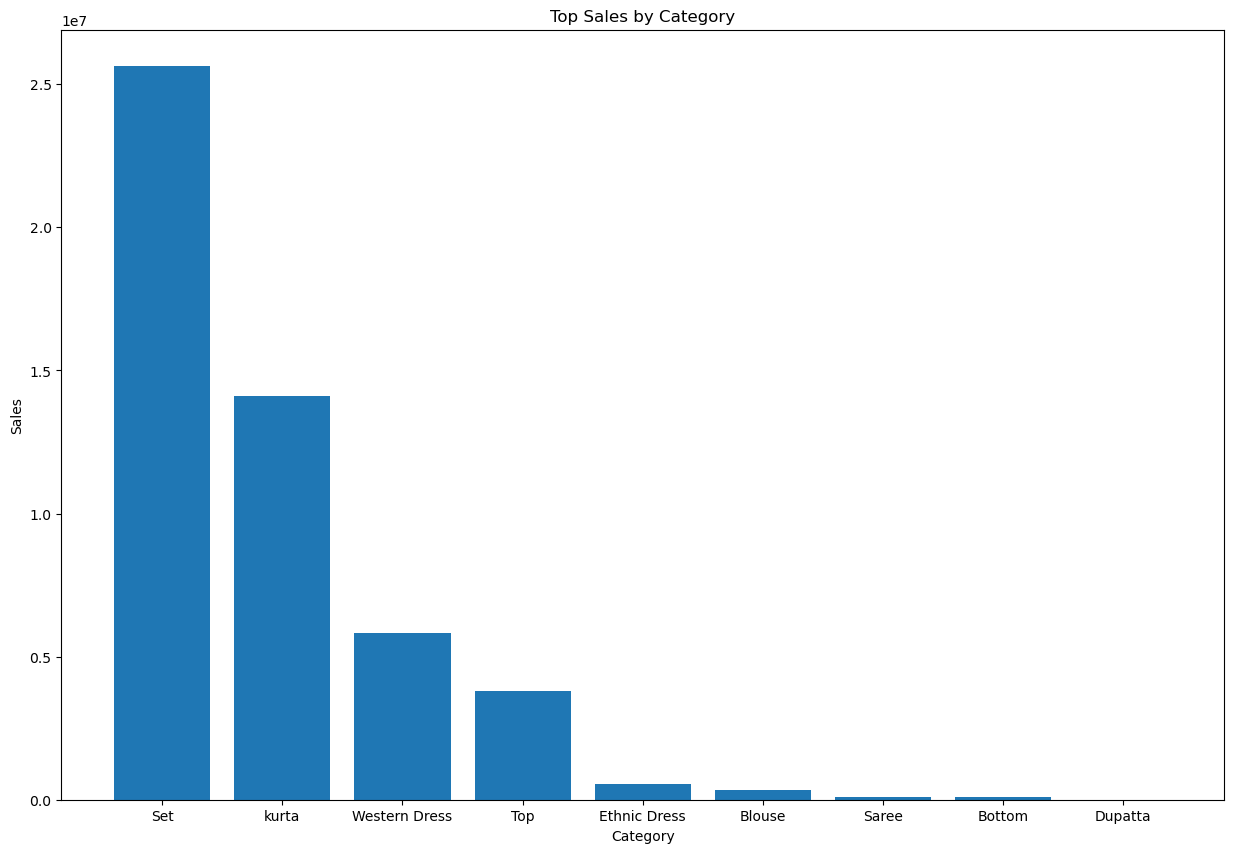

In [18]:
data_category = data[['category', 'sales']].groupby('category').sum().sort_values('sales', ascending=False)
data_category = data_category.reset_index()

plt.figure(figsize=(15, 10))
plt.bar(data_category['category'], data_category['sales'])
plt.xlabel('Category')
plt.ylabel('Sales')
plt.title('Top Sales by Category')
plt.show()

The `Set` category is the top-selling product category, followed by `Kurta` and `Western Dress`. On the other hand, `Dupatta` is the least popular category.

### Distribution of Products Sold by Category and Size

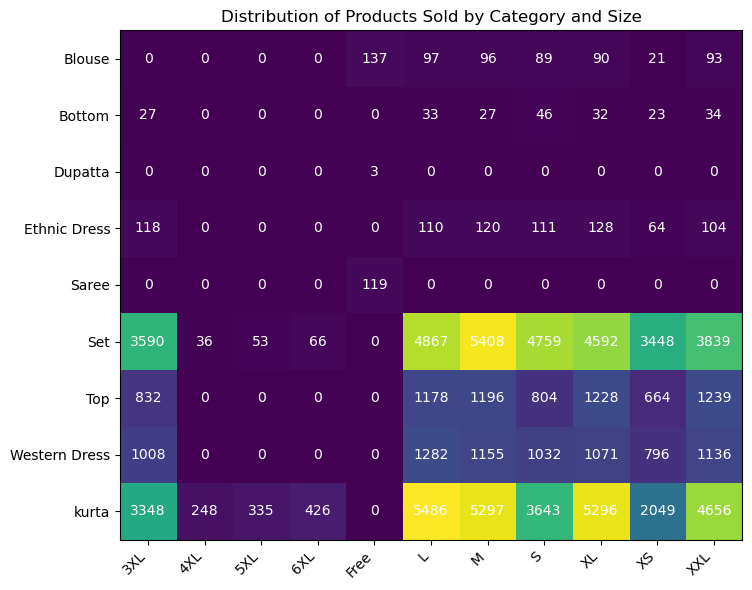

In [19]:
# Step 1: Count product based on its category and size jumlah produk berdasarkan category dan size
data_cat_size = data.groupby(['category', 'size'])['amazon_standard_id'].count().unstack(fill_value=0)

# Step 2: Buat plot
fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(data_cat_size.values)

# Step 3: Set ticks dan label-nya
ax.set_xticks(range(len(data_cat_size.columns)))
ax.set_xticklabels(data_cat_size.columns, rotation=45, ha="right")

ax.set_yticks(range(len(data_cat_size.index)))
ax.set_yticklabels(data_cat_size.index)

# Step 4: Tambahkan label di tiap sel
for i in range(len(data_cat_size.index)):
    for j in range(len(data_cat_size.columns)):
        text = ax.text(j, i, data_cat_size.values[i, j],
                       ha="center", va="center", color="w")

# Step 5: Judul dan layout
ax.set_title("Distribution of Products Sold by Category and Size")
fig.tight_layout()
plt.show()


`Set` as the top-selling product category sold the most at size M, followed by L and S. There is no free size in this product category.
`Kurta` sold the most at L, followed by M and XL and similar with `Set`, there is no free size in this product category.
`Dupatta` only sold at 3 in free size.

### Distribution of Promotion Used

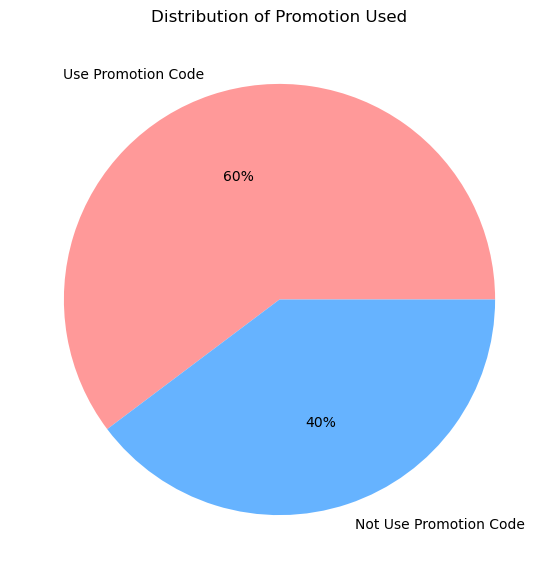

In [20]:
data_pie = data['promotion_used'].value_counts()
# Creating plot
fig = plt.figure(figsize=(10, 7))
plt.pie(data_pie, labels=data_pie.index.map({True: 'Use Promotion Code', False: 'Not Use Promotion Code'}), autopct='%.0f%%', colors=['#ff9999', '#66b3ff'])
plt.title('Distribution of Promotion Used')
# show plot
plt.show()

Most of our customers tends to use promotion code when buying our products, while only 40% decided to not use promotion code.